# Belgian production network model

## Prototyping

*Original code by Cyril Garneau. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [3]:
from covid19model.data.economic_parameters import get_economic_parameters
from covid19model.models.economic_utils import *

### Load economic parameters

In [293]:
pars = get_economic_parameters()

### Testing of demand functions

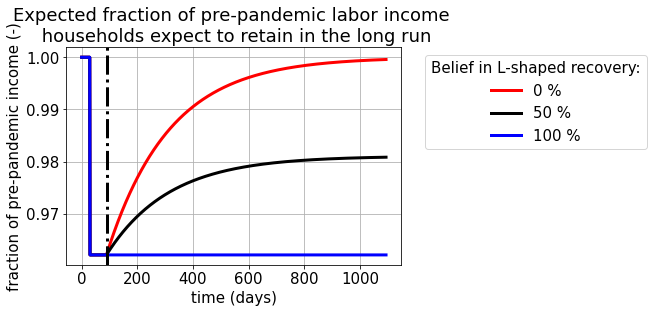

In [294]:
rho = 1-(1-0.6)/90 # recovery time constant
L = 0.2 # fraction of population expecting L-shaped recovery

t_start_lockdown = 30
t_end_lockdown = 30+60
t_end_pandemic = 30+60+365
simtime = 365*3

zeta_previous = 1

fig,ax = plt.subplots()

color=['red','black','blue']
i=0
for L in [0,0.5,1]:
    zeta=[]
    epsilon = np.empty(shape=[63,simtime])
    for time in np.arange(simtime):
        zeta.append(household_income_expectations(time,zeta_previous,t_start_lockdown,t_end_lockdown,pars['l_0'],sum((1-pars['l_s'])*pars['l_0']),rho,L))
        zeta_previous = zeta[-1]
        epsilon[:,time] = list(household_demand_shock(time,t_start_lockdown,t_end_lockdown,t_end_pandemic,pars['c_s'],pars['on_site']))

    ax.plot(np.arange(simtime),zeta,color=color[i])
    i=i+1
    
ax.axvline(t_end_lockdown,color='black',ls='-.')
ax.set_title('Expected fraction of pre-pandemic labor income \n households expect to retain in the long run')
ax.set_xlabel('time (days)')
ax.set_ylabel('fraction of pre-pandemic income (-)')
lgd=ax.legend(['0 %','50 %', '100 %'],bbox_to_anchor=(1.05, 1), loc='upper left',title='Belief in L-shaped recovery:')
ax.grid('on')
fig.savefig('l_p.jpg',dpi=400,bbox_extra_artists=(lgd,), bbox_inches='tight')

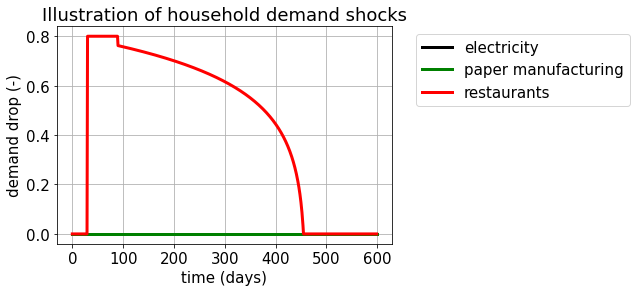

In [295]:
fig,ax = plt.subplots()
plottime = 600
ax.plot(np.arange(plottime),epsilon[23,:plottime],color='black')
ax.plot(np.arange(plottime),epsilon[7,:plottime],color='green')
ax.plot(np.arange(plottime),epsilon[-28,:plottime],color='red')
ax.plot()
ax.plot()
ax.set_title('Illustration of household demand shocks')
ax.set_xlabel('time (days)')
ax.set_ylabel('demand drop (-)')
lgd=ax.legend(['electricity','paper manufacturing','restaurants'],bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid('on')
fig.savefig('demand_shocks.jpg',dpi=400,bbox_extra_artists=(lgd,), bbox_inches='tight')

### Testing of full model

In [304]:
# Parameters
# ----------
rho = 1-(1-0.6)/90 # recovery time constant
L = 0 # fraction of population expecting L-shaped recovery
delta_S = 0.5
m = sum(pars['c_0'])/sum(pars['l_0'])
tau = 10
b = 0
gamma_F = 1/7
gamma_H = 1/30

# Timing
# ------
t_start_lockdown = 30
t_end_lockdown = 30+60
t_end_pandemic = 30+60+365
simtime = 500

# Initialisation
# --------------
theta_0 = pars['c_0']/sum(pars['c_0'])
zeta_previous = 1
c_total_previous = sum(pars['c_0']) # Total household demand under business-as-usual
d_t_previous = pars['x_0'] # Demand = Output at start simulation
S_t = pars['S_0']

c_t_array = np.expand_dims(pars['c_0'],axis=1)
O_t_array = np.expand_dims(pars['O_j'],axis=1)
S_t_array = np.expand_dims(np.sum(pars['S_0'],axis=1),axis=1)
d_t_array = np.expand_dims(pars['x_0'],axis=1)
x_t_array = np.expand_dims(pars['x_0'],axis=1)
f_t_array = np.expand_dims(pars['f_0'],axis=1)
l_t = pars['l_0']
l_t_array = np.expand_dims(pars['l_0'],axis=1)

# Simulation loop
# ---------------
for time in np.arange(1,simtime):
    
    # Demand and supply shocks
    # ------------------------
    # Labor
    epsilon_S = labor_supply_shock(time,t_start_lockdown,t_end_lockdown,pars['l_s'])
    # Household demand
    epsilon_D = household_demand_shock(time,t_start_lockdown,t_end_lockdown,t_end_pandemic,pars['c_s'],pars['on_site'])
    # Other demand
    if time < t_start_lockdown:
        f_t = pars['f_0']
    elif ((time >= t_start_lockdown) & (time < t_end_lockdown)):
        f_t = pars['f_0']*(1-pars['f_s'])
    else:
        f_t = pars['f_0']

    # Government intervention
    # -----------------------
    l_t_star = labor_compensation_intervention(time, t_start_lockdown, t_end_pandemic, l_t, pars['l_0'], b)

    # Productive capacity
    # -------------------
    x_t_cap = calc_labor_restriction(pars['x_0'],pars['l_0'],l_t)

    # Input bottlenecks
    # -----------------
    x_t_inp = calc_input_restriction(S_t,pars['A'],pars['C'])

    # Total consumer demand
    # ---------------------

    # Compute preference vector
    theta = household_preference_shock(epsilon_D, theta_0)
    # Compute aggregate demand shock
    epsilon_t = aggregate_demand_shock(epsilon_D, theta_0, delta_S, rho)
    # Compute expected long term labor income (Eq. 22, 23)
    zeta = household_income_expectations(time,zeta_previous,t_start_lockdown,t_end_lockdown,pars['l_0'],sum((1-pars['l_s'])*pars['l_0']),rho,L)
    l_p = zeta*sum(pars['l_0'])
    # Compute total consumer demand (per sector)
    c_t = theta*calc_household_demand(c_total_previous,l_t_star,l_p,epsilon_t,rho,m)
    c_t_array = np.append(c_t_array, np.expand_dims(c_t,axis=1), axis = 1)

    # Intermediate demand
    # -------------------
    O = calc_intermediate_demand(d_t_previous,S_t,pars['A'],pars['S_0'],tau)
    O_t_array = np.append(O_t_array,np.expand_dims(np.sum(O,axis=1),axis=1),axis=1)

    # Total demand
    # ------------
    d_t = calc_total_demand(O,c_t,f_t)
    d_t_array = np.append(d_t_array, np.expand_dims(d_t,axis=1), axis=1)

    # Leontief production function
    # ----------------------------
    x_t = leontief(x_t_cap, x_t_inp, d_t)
    x_t_array = np.append(x_t_array, np.expand_dims(x_t,axis=1), axis=1)
    
    # Rationing
    # ---------
    O,c_t,f_t = rationing(x_t,d_t,O,c_t,f_t)
    f_t_array = np.append(f_t_array, np.expand_dims(f_t,axis=1), axis = 1)
    
    # Update inventories
    # ------------------
    S_t = inventory_updating(S_t,O,x_t,pars['A'])
    S_t_array = np.append(S_t_array, np.expand_dims(np.sum(S_t,axis=1),axis=1), axis=1)
    
    # Hire/fire workers
    # -----------------
    l_t = hiring_firing(l_t, pars['l_0'], pars['x_0'], x_t_inp, x_t_cap, d_t, gamma_F, gamma_H, epsilon_S)
    l_t_array = np.append(l_t_array, np.expand_dims(l_t,axis=1), axis=1)
    
    # Update other states
    # -------------------
    c_total_previous = sum(theta*calc_household_demand(c_total_previous,l_t_star,l_p,epsilon_t,rho,m))
    d_t_previous = d_t
    zeta_previous = zeta

[autoreload of covid19model.models.models failed: Traceback (most recent call last):
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 292, in update_class
    if (old_obj == new_obj) is True:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
]


TypeError: labor_supply_shock() missing 1 required positional argument: 'l_s'

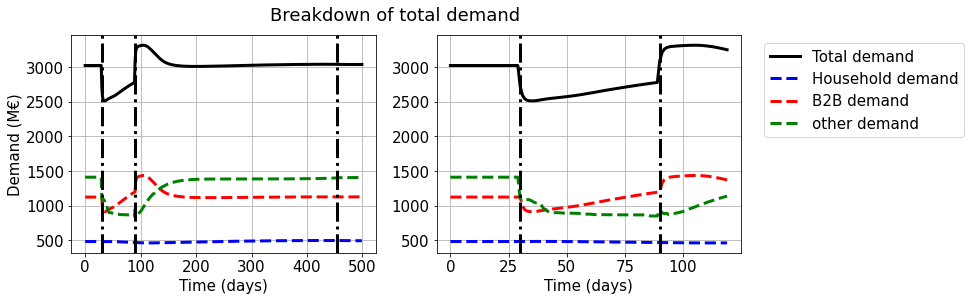

In [297]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
fig.suptitle('Breakdown of total demand')

ax1.plot(np.arange(0,simtime),np.sum(d_t_array,axis=0),color='black')
ax1.plot(np.arange(0,simtime),np.sum(c_t_array,axis=0),color='blue',ls='--')
ax1.plot(np.arange(0,simtime),np.sum(O_t_array,axis=0),color='red',ls='--')
ax1.plot(np.arange(0,simtime),np.sum(f_t_array,axis=0),color='green',ls='--')
ax1.axvline(t_start_lockdown,color='black',linestyle='-.')
ax1.axvline(t_end_lockdown,color='black',linestyle='-.')
ax1.axvline(t_end_pandemic,color='black',linestyle='-.')
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Demand (M€)')
ax1.grid('on')

ax2.plot(np.arange(0,t_end_lockdown+30),np.sum(d_t_array,axis=0)[0:t_end_lockdown+30],color='black')
ax2.plot(np.arange(0,t_end_lockdown+30),np.sum(c_t_array,axis=0)[0:t_end_lockdown+30],color='blue',ls='--')
ax2.plot(np.arange(0,t_end_lockdown+30),np.sum(O_t_array,axis=0)[0:t_end_lockdown+30],color='red',ls='--')
ax2.plot(np.arange(0,t_end_lockdown+30),np.sum(f_t_array,axis=0)[0:t_end_lockdown+30],color='green',ls='--')
ax2.axvline(t_start_lockdown,color='black',linestyle='-.')
ax2.axvline(t_end_lockdown,color='black',linestyle='-.')
ax2.set_xlabel('Time (days)')
lgd=ax2.legend(['Total demand','Household demand','B2B demand','other demand'],bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid('on')
fig.savefig('demand_breakdown.jpg',dpi=400,bbox_extra_artists=(lgd,), bbox_inches='tight')

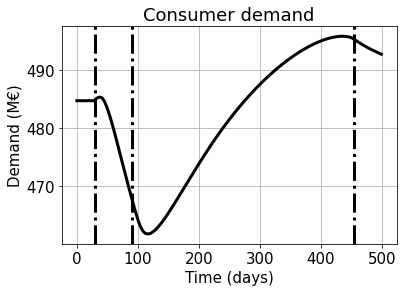

In [277]:
fig,ax=plt.subplots()
ax.plot(np.arange(0,simtime),np.sum(c_t_array,axis=0),color='black')
ax.axvline(t_start_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_pandemic,color='black',linestyle='-.')
ax.set_title('Consumer demand')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Demand (M€)')
ax.grid('on')
fig.savefig('consumer_government.jpg',dpi=400)

Text(0, 0.5, 'Output (M€)')

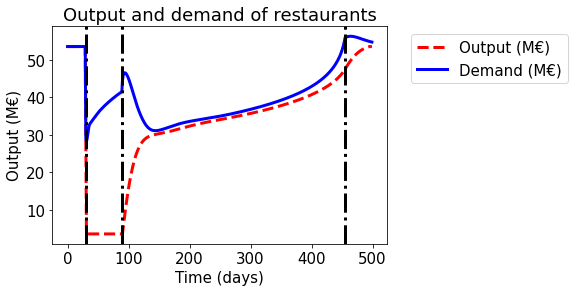

In [278]:
fig,ax=plt.subplots()
ax.plot(np.arange(0,simtime),x_t_array[-28,:],color='red',ls='--')
ax.plot(np.arange(0,simtime),d_t_array[-28,:],color='blue')
ax.axvline(t_start_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_pandemic,color='black',linestyle='-.')
ax.set_title('Output and demand of restaurants')
ax.legend(['Output (M€)','Demand (M€)'],bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Output (M€)')

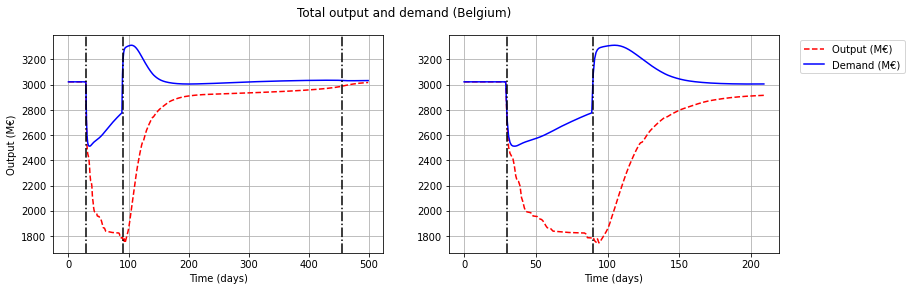

In [14]:
fig,(ax1,ax2)=plt.subplots(1, 2,figsize=(13,4))

fig.suptitle('Total output and demand (Belgium)')
ax1.plot(np.arange(0,simtime),np.sum(x_t_array,axis=0),color='red',ls='--')
ax1.plot(np.arange(0,simtime),np.sum(d_t_array,axis=0),color='blue')
ax1.axvline(t_start_lockdown,color='black',linestyle='-.')
ax1.axvline(t_end_lockdown,color='black',linestyle='-.')
ax1.axvline(t_end_pandemic,color='black',linestyle='-.')
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Output (M€)')
ax1.grid('on')

ax2.plot(np.arange(0,t_end_lockdown+120),np.sum(x_t_array,axis=0)[0:t_end_lockdown+120],color='red',ls='--')
ax2.plot(np.arange(0,t_end_lockdown+120),np.sum(d_t_array,axis=0)[0:t_end_lockdown+120],color='blue')
ax2.axvline(t_start_lockdown,color='black',linestyle='-.')
ax2.axvline(t_end_lockdown,color='black',linestyle='-.')
lgd=ax2.legend(['Output (M€)','Demand (M€)'],bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.set_xlabel('Time (days)')
ax2.grid('on')

fig.savefig('total_output_demand.jpg',dpi=400,bbox_extra_artists=(lgd,), bbox_inches='tight')

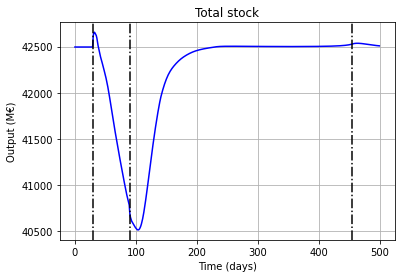

In [15]:
fig,ax=plt.subplots()
ax.plot(np.arange(0,simtime),np.sum(S_t_array,axis=0),color='blue')
ax.axvline(t_start_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_pandemic,color='black',linestyle='-.')
ax.set_title('Total stock')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Output (M€)')
ax.grid('on')
plt.savefig('total_stock.jpg',dpi=400)

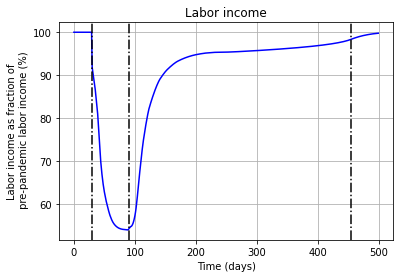

In [16]:
fig,ax=plt.subplots()
ax.plot(np.arange(0,simtime),(np.sum(l_t_array,axis=0)/np.sum(pars['l_0'],axis=0)*100),color='blue')
ax.axvline(t_start_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_pandemic,color='black',linestyle='-.')
ax.set_title('Labor income')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Labor income as fraction of\n pre-pandemic labor income (%)')
ax.grid('on')
fig.savefig('active_workers.jpg',dpi=400)

In [17]:
x_t_10 = np.matmul(get_conversion_matrix('NACE21_NACE10'),np.matmul(get_conversion_matrix('NACE38_NACE21'),np.matmul(get_conversion_matrix('NACE64_NACE38'),np.expand_dims(x_t_array[:,0],axis=1))))
d_t_10 = np.matmul(get_conversion_matrix('NACE21_NACE10'),np.matmul(get_conversion_matrix('NACE38_NACE21'),np.matmul(get_conversion_matrix('NACE64_NACE38'),np.expand_dims(d_t_array[:,0],axis=1))))
l_t_10 = np.matmul(get_conversion_matrix('NACE21_NACE10'),np.matmul(get_conversion_matrix('NACE38_NACE21'),np.matmul(get_conversion_matrix('NACE64_NACE38'),np.expand_dims(l_t_array[:,0],axis=1))))

for i in range(1,x_t_array[0,:].shape[0]):
    print(i)
    x_t_10 = np.append(x_t_10,np.matmul(get_conversion_matrix('NACE21_NACE10'),np.matmul(get_conversion_matrix('NACE38_NACE21'),np.matmul(get_conversion_matrix('NACE64_NACE38'),np.expand_dims(x_t_array[:,i],axis=1)))),axis=1)
    d_t_10 = np.append(d_t_10,np.matmul(get_conversion_matrix('NACE21_NACE10'),np.matmul(get_conversion_matrix('NACE38_NACE21'),np.matmul(get_conversion_matrix('NACE64_NACE38'),np.expand_dims(d_t_array[:,i],axis=1)))),axis=1)
    l_t_10 = np.append(l_t_10,np.matmul(get_conversion_matrix('NACE21_NACE10'),np.matmul(get_conversion_matrix('NACE38_NACE21'),np.matmul(get_conversion_matrix('NACE64_NACE38'),np.expand_dims(l_t_array[:,i],axis=1)))),axis=1)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [18]:
labels=pd.read_excel("../../data/interim/economical/conversion_matrices.xlsx", sheet_name = 'NACE 21 to NACE 10', header=[0], index_col=[0]).index.values

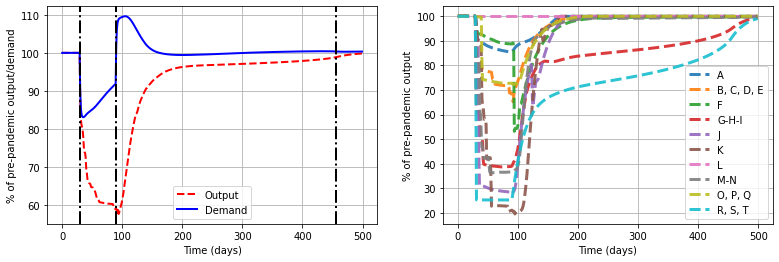

In [19]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(13,4))

ax1.plot(np.arange(0,simtime),np.sum(x_t_array,axis=0)/np.sum(x_t_array,axis=0)[0]*100,color='red',ls='--',linewidth=2)
ax1.plot(np.arange(0,simtime),np.sum(d_t_array,axis=0)/np.sum(d_t_array,axis=0)[0]*100,color='blue',linewidth=2)
ax1.axvline(t_start_lockdown,color='black',linestyle='-.',linewidth=2)
ax1.axvline(t_end_lockdown,color='black',linestyle='-.',linewidth=2)
ax1.axvline(t_end_pandemic,color='black',linestyle='-.',linewidth=2)
ax1.legend(['Output','Demand'])
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('% of pre-pandemic output/demand')
ax1.grid('on')

for i in range(x_t_10.shape[0]):
    ax2.plot(np.arange(0,simtime),(x_t_10[i,:]/x_t_10[i,0]*100),ls='--',linewidth=3, alpha=0.9)
    
ax2.grid('on')
ax2.set_xlabel('Time (days)')
ax2.set_ylabel('% of pre-pandemic output')
ax2.legend(labels)
fig.savefig('output_breakdown_NACE10.jpg',dpi=400, bbox_inches='tight')

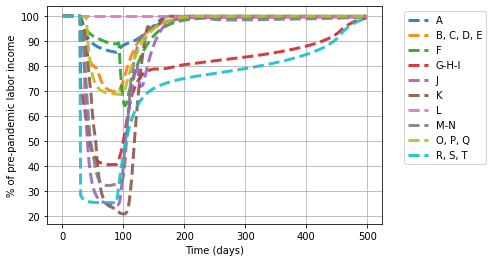

In [20]:
fig,ax=plt.subplots()

for i in range(x_t_10.shape[0]):
    ax.plot(np.arange(0,simtime),l_t_10[i,:]/l_t_10[i,0]*100,ls='--',linewidth=3, alpha=0.9)
    
ax.grid('on')
ax.set_xlabel('Time (days)')
ax.set_ylabel('% of pre-pandemic labor income')
ax.legend(labels,bbox_to_anchor=(1.05, 1), loc='upper left')
fig.savefig('labor_breakdown_NACE10.jpg',dpi=400, bbox_inches='tight')

In [21]:
import datetime
df = pd.read_excel("../../data/interim/economical/ERMG_revenue_survey.xlsx",index_col=[0], header=[0])
datetime_dates=[datetime.datetime.strptime(date,"%Y-%m-%d") for date in df.columns]

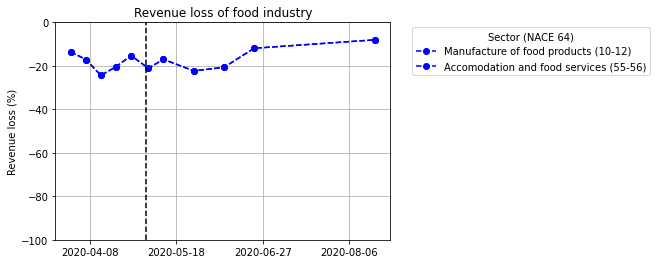

In [22]:
# Manufacture of food products

fig,ax = plt.subplots()

ax.plot(datetime_dates,df.loc['10-12'],color='blue',ls='--',marker='o')
ax.plot(datetime_dates,df.loc['10-12'],color='blue',ls='--',marker='o')

ax.set_ylim([-100,0])
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))
ax.axvline(datetime.datetime.strptime('2020-05-04',"%Y-%m-%d"),color='black',ls='--')
ax.set_ylabel('Revenue loss (%)')
ax.set_title('Revenue loss of food industry')
lgd=ax.legend(['Manufacture of food products (10-12)', 'Accomodation and food services (55-56)'], title='Sector (NACE 64)', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid('on')
fig.savefig('food_sector.jpg',dpi=400,bbox_extra_artists=(lgd,), bbox_inches='tight')

### Attempt to incorporate in modeling framework of BIOMATH

In [4]:
from covid19model.models import models
from covid19model.data.economic_parameters import get_economic_parameters
from covid19model.models.economic_utils import *

In [5]:
# Load the parameters using `get_economic_parameters()`.
params = get_economic_parameters()

# Parameters
# ----------
start_date = '2020-03-01'
end_date = '2020-12-31'
t_start_lockdown = pd.Timestamp('2020-03-15')
t_end_lockdown =pd.Timestamp('2020-05-04')
t_end_pandemic = pd.Timestamp('2020-08-01')
                    
params.update({'rho': 1-(1-0.6)/90, # Economic recovery time (0.6 quarters?)
               'delta_S': 0.5, # household savings rate (delta_S = 1; households save all money they are not spending due to shock)
               'L': 0.5, # Fraction of population believing in L-shaped recovery
               'l_start_lockdown': sum((1-params['l_s'])*params['l_0']), # Verify this must be the sum
               'zeta': 1,
               'tau': 10, # Restock rate (days)
               'gamma_F': 1/7, # Firing rate (days-1)
               'gamma_H': 1/30 }) # Hiring rate (days-1)


# Time-dependent parameters
# -------------------------
params.update({'epsilon_S': np.zeros([params['c_s'].shape[0]]),
                'epsilon_D': np.zeros([params['c_s'].shape[0]]),
                'epsilon_F': np.zeros([params['c_s'].shape[0]]),
                't_start_lockdown': t_start_lockdown,
                't_end_lockdown': t_end_lockdown,
                't_end_pandemic': t_end_pandemic,
                'b': 0,
                'b_s': 0,
                't_start_compensation': pd.Timestamp('2020-04-01'),
                't_end_compensation': pd.Timestamp('2020-07-01')})

# Load initial states
initial_states = {'x': params['x_0'],
                  'c': params['c_0'],
                  'c_desired': params['c_0'],
                  'f': params['f_0'],
                  'd': params['x_0'],
                  'l': params['l_0'],
                  'O': params['O_j'],
                  'S': params['S_0']}

# Initialize the model
model = models.Economic_Model(initial_states, params, discrete=True, time_dependent_parameters={'epsilon_S': labor_supply_shock,
                                                                                                'epsilon_D': household_demand_shock,
                                                                                                'epsilon_F': other_demand_shock,
                                                                                                'b': government_furloughing,
                                                                                                'zeta': compute_income_expectations})

In [6]:
out=model.sim(end_date, start_date=start_date, warmup=0)

/home/twallema/Documents/PhD/Corona/Python/git/COVID19-Model/src/covid19model/models/economic_utils.py:48: RuntimeWarning: invalid value encountered in true_divide
  x_t[i] = np.nanmin(S_t[np.where(C[i,:] == 1),i]/A[np.where(C[i,:] == 1),i])
/home/twallema/Documents/PhD/Corona/Python/git/COVID19-Model/src/covid19model/models/economic_utils.py:48: RuntimeWarning: All-NaN slice encountered
  x_t[i] = np.nanmin(S_t[np.where(C[i,:] == 1),i]/A[np.where(C[i,:] == 1),i])


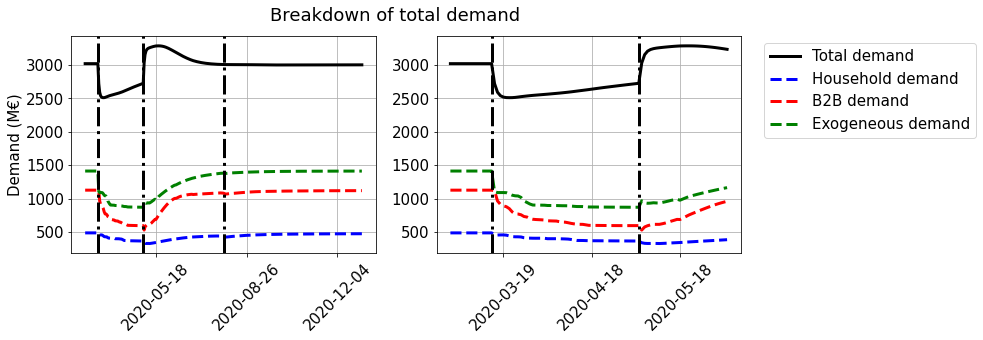

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
fig.suptitle('Breakdown of total demand')

ax1.plot(out['time'],out['d'].sum(dim='A'),color='black')
ax1.plot(out['time'],out['c'].sum(dim='A'),color='blue',ls='--')
ax1.plot(out['time'],out['O'].sum(dim='A'),color='red',ls='--')
ax1.plot(out['time'],out['f'].sum(dim='A'),color='green',ls='--')
ax1.axvline(t_start_lockdown,color='black',linestyle='-.')
ax1.axvline(t_end_lockdown,color='black',linestyle='-.')
ax1.axvline(t_end_pandemic,color='black',linestyle='-.')
ax1.set_ylabel('Demand (M€)')
ax1.grid('on')
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
    
ax2.plot(out['time'].sel(time=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),out['d'].sum(dim='A').sel(time=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),color='black')
ax2.plot(out['time'].sel(time=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),out['c'].sum(dim='A').sel(time=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),color='blue',ls='--')
ax2.plot(out['time'].sel(time=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),out['O'].sum(dim='A').sel(time=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),color='red',ls='--')
ax2.plot(out['time'].sel(time=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),out['f'].sum(dim='A').sel(time=slice(start_date, t_end_lockdown+pd.Timedelta(days=30))),color='green',ls='--')
ax2.axvline(t_start_lockdown,color='black',linestyle='-.')
ax2.axvline(t_end_lockdown,color='black',linestyle='-.')
ax2.xaxis.set_major_locator(plt.MaxNLocator(4))
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)
lgd=ax2.legend(['Total demand','Household demand','B2B demand','Exogeneous demand'],bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid('on')

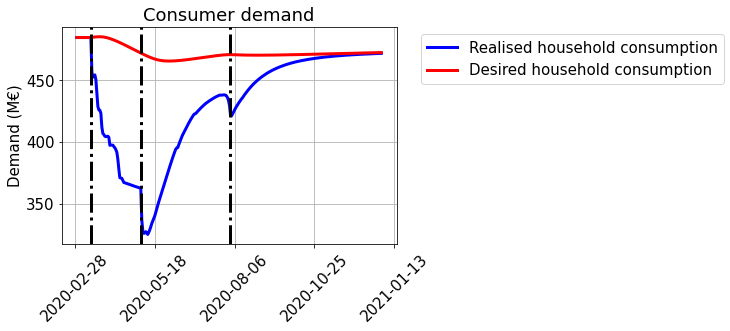

In [8]:
fig,ax=plt.subplots()
ax.plot(out['time'],out['c'].sum(dim='A'),color='blue')
ax.plot(out['time'],out['c_desired'].sum(dim='A'),color='red')
ax.axvline(t_start_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_pandemic,color='black',linestyle='-.')
ax.set_title('Consumer demand')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_ylabel('Demand (M€)')
lgd=ax.legend(['Realised household consumption','Desired household consumption'],bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid('on')

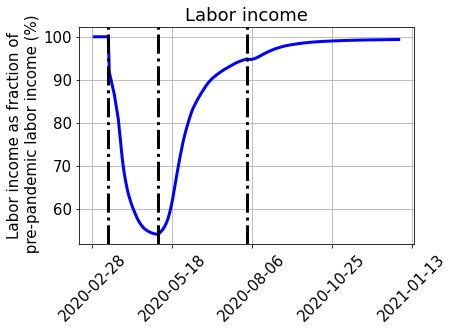

In [9]:
fig,ax=plt.subplots()
ax.plot(out['time'],(out['l'].sum(dim='A')/np.sum(params['l_0'],axis=0)*100),color='blue')
ax.axvline(t_start_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_pandemic,color='black',linestyle='-.')
ax.set_title('Labor income')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_ylabel('Labor income as fraction of\n pre-pandemic labor income (%)')
ax.grid('on')

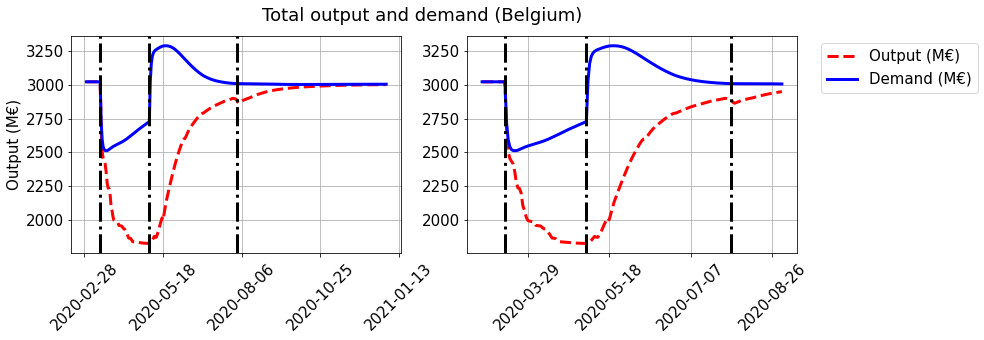

In [10]:
fig,(ax1,ax2)=plt.subplots(1, 2,figsize=(13,4))

fig.suptitle('Total output and demand (Belgium)')
ax1.plot(out['time'],out['x'].sum(dim='A'),color='red',ls='--')
ax1.plot(out['time'],out['d'].sum(dim='A'),color='blue')
ax1.axvline(t_start_lockdown,color='black',linestyle='-.')
ax1.axvline(t_end_lockdown,color='black',linestyle='-.')
ax1.axvline(t_end_pandemic,color='black',linestyle='-.')
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.set_ylabel('Output (M€)')
ax1.grid('on')

ax2.plot(out['time'].sel(time=slice(start_date, t_end_lockdown+pd.Timedelta(days=120))),out['x'].sum(dim='A').sel(time=slice(start_date, t_end_lockdown+pd.Timedelta(days=120))),color='red',ls='--')
ax2.plot(out['time'].sel(time=slice(start_date, t_end_lockdown+pd.Timedelta(days=120))),out['d'].sum(dim='A').sel(time=slice(start_date, t_end_lockdown+pd.Timedelta(days=120))),color='blue')
ax2.axvline(t_start_lockdown,color='black',linestyle='-.')
ax2.axvline(t_end_lockdown,color='black',linestyle='-.')
ax2.axvline(t_end_pandemic,color='black',linestyle='-.')
ax2.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)
lgd=ax2.legend(['Output (M€)','Demand (M€)'],bbox_to_anchor=(1.05, 1), loc='upper left')

ax2.grid('on')

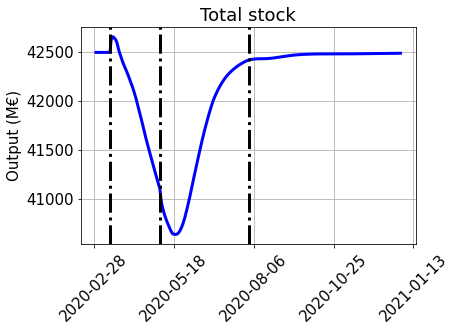

In [11]:
fig,ax=plt.subplots()
ax.plot(out['time'],out['S'].sum(dim='A').sum(dim='A'),color='blue')
ax.axvline(t_start_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_lockdown,color='black',linestyle='-.')
ax.axvline(t_end_pandemic,color='black',linestyle='-.')
ax.set_title('Total stock')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_ylabel('Output (M€)')
ax.grid('on')